**You will find here all the results related to the first approach in the Black & Scholes model.**

In [ ]:
import numpy as np
import pandas as pd
# We import from assets.py all the parameters for the B&S model
from assets import N, S0, Neuler, T, K, K_AC, AB, DB
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# We import the function that will alow to build neural networks from model.py
from model import DNN
from numpy.linalg import matrix_rank
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv
import seaborn as sns

import pickle

from assets import f_Call_Basket, f_Put_Worst_Of, f_Digit_Basket, f_Asian_Arithmetic, f_AutoCall

In [ ]:
summary = {'Number of assets' : N, '(Neuler, T)' : (Neuler, T), '(K, S0)' : (K, S0)}
summary

{'Number of assets': 100, '(Neuler, T)': (10, 1), '(K, S0)': (100, 100)}

In [ ]:
nb_samples = int(1e5)
M_simulation = int(1e4)
sns.set(style="darkgrid")

In [ ]:
def simulation(W, f, N=N):
    Z_simul = np.random.randn(M_simulation, N)
    y = f(Z_simul)

    U = W/ np.sqrt(np.sum(W * W, axis = 1)).reshape(-1,1)
    V = null_space(U).T
    M = np.concatenate((U,V), axis = 0)
    
    Z_simul = np.random.randn(M_simulation, N)
    Z_tilde = U@Z_simul.T
    n = Z_tilde.shape[0]
    tmp = np.concatenate((Z_tilde, np.zeros((N-n, M_simulation))))
    control_variate = f((inv(M)@tmp).T)
    control_variate_mean = np.mean(control_variate)
    Y_control = f(Z_simul) - control_variate + control_variate_mean
    return y, Y_control


In [ ]:
def plot_simulation(y, Y_control, bins = [100,100, 100,100]):
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    plt.hist(y, bins = bins[0], label = 'mean = %.3f\nvar = %.5f'%(y.mean(), y.var()))
    plt.title('distribution of the initial_variable')
    plt.legend()
    plt.subplot(1,3,2)
    plt.hist(Y_control, bins = bins[1], label = 'mean = %.3f\nvar = %.5f'%(Y_control.mean(), Y_control.var()), color='orange')
    plt.title('distribution using control variate')
    plt.legend()
    plt.subplot(1,3,3)
    plt.hist(y, bins = bins[2], label = 'initial variable')
    plt.hist(Y_control,bins = bins[3], label = "control variate ", color='orange')
    plt.title('comparaison of distribution')
    plt.legend()
    plt.show()

# Basket Call Option

### 1. Data generation
we generate $N_{samples}>10^5$ samples for our training and test set

In [ ]:
Z = multivariate_normal.rvs(cov = np.eye(N), size=nb_samples)
y = f_Call_Basket(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_basket = DNN(N, n = 10)

In [ ]:
print(nnmodel_basket.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1000      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
nnmodel_basket.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 50)

# Save the model
filename = 'Basket_BS.sav'
#pickle.dump(nnmodel_basket, open(filename, 'wb'))

Epoch 1/1000
5000/5000 [==============================] - 7s 1ms/step - loss: 19.1376 - mse: 19.1376 - val_loss: 0.7663 - val_mse: 0.7663
Epoch 2/1000
5000/5000 [==============================] - 7s 1ms/step - loss: 3.1402 - mse: 3.1402 - val_loss: 3.8301 - val_mse: 3.8301
Epoch 3/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 3.0378 - mse: 3.0378 - val_loss: 1.1441 - val_mse: 1.1441
Epoch 4/1000
5000/5000 [==============================] - 5s 943us/step - loss: 3.1432 - mse: 3.1432 - val_loss: 0.2591 - val_mse: 0.2591
Epoch 5/1000
5000/5000 [==============================] - 5s 944us/step - loss: 1.7400 - mse: 1.7400 - val_loss: 0.8255 - val_mse: 0.8255
Epoch 6/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 2.2341 - mse: 2.2341 - val_loss: 1.4953 - val_mse: 1.4953
Epoch 7/1000
5000/5000 [==============================] - 4s 897us/step - loss: 1.8827 - mse: 1.8827 - val_loss: 1.1686 - val_mse: 1.1686
Epoch 8/1000
5000/5000 [================

### 3. Test  and evaluation of the model
We evaluate our model using Mean Square Error:  
    - first we generate a test set sample  
    - then we predict and evaluate the model

In [ ]:
Z = multivariate_normal.rvs(cov = np.eye(N), size=M_simulation)
y = f_Call_Basket(Z)

In [ ]:
y_pred = nnmodel_basket.model.predict(Z)

313/313 [==============================] - 0s 576us/step


In [ ]:
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

Monte Carlo price = 14.64. Control variate price = 14.7


0.3539254287490384

### 4. Simulation

In [ ]:
U = nnmodel_basket.model.get_weights()[0].T

In [ ]:
matrix_rank(U) # we check that our matrix have maximal rank

10

In [ ]:
y, Y_control = simulation(U, f_Call_Basket)

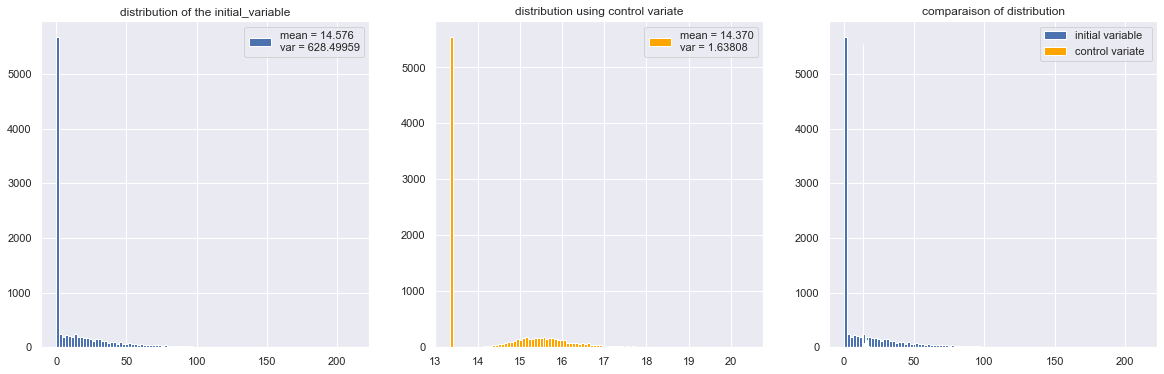

In [ ]:
plot_simulation(y, Y_control)

# Put  Worst-Of  Option

In [ ]:
def simul_put_worst_of(k):
    Z = multivariate_normal.rvs(cov = np.eye(N), size=M_simulation)
    y = f_Put_Worst_Of(Z, K = k*S0)
    X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)
    
    model = DNN(N, n = 10)
    model.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True)
    
    U = model.model.get_weights()[0].T
    f = lambda x : f_Put_Worst_Of(x, K = k*S0)
    y, Y_control = simulation(U, f)
    return y, Y_control

### 1. Data generation

In [ ]:
Z = multivariate_normal.rvs(cov = np.eye(N), size=nb_samples)
y = f_Put_Worst_Of(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_worst = DNN(N, n = 15)

In [ ]:
nnmodel_worst.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True)

Epoch 1/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 42.6407 - mse: 42.6407 - val_loss: 25.4353 - val_mse: 25.4353
Epoch 2/1000
5000/5000 [==============================] - 5s 1ms/step - loss: 26.0887 - mse: 26.0887 - val_loss: 24.0473 - val_mse: 24.0473
Epoch 3/1000
5000/5000 [==============================] - 4s 892us/step - loss: 24.5719 - mse: 24.5719 - val_loss: 23.8741 - val_mse: 23.8741
Epoch 4/1000
5000/5000 [==============================] - 5s 907us/step - loss: 23.9875 - mse: 23.9875 - val_loss: 23.6429 - val_mse: 23.6429
Epoch 5/1000
5000/5000 [==============================] - 4s 890us/step - loss: 23.6674 - mse: 23.6674 - val_loss: 23.9676 - val_mse: 23.9676
Epoch 6/1000
5000/5000 [==============================] - 5s 917us/step - loss: 23.3780 - mse: 23.3780 - val_loss: 22.4035 - val_mse: 22.4035
Epoch 7/1000
5000/5000 [==============================] - 4s 887us/step - loss: 23.2637 - mse: 23.2637 - val_loss: 22.6422 - val_mse: 22.6422
Epoch 8/10

### 3. Test  and evaluation of the model

In [ ]:
Z = multivariate_normal.rvs(cov = np.eye(N), size=M_simulation)
y = f_Put_Worst_Of(Z)
y_pred = nnmodel_worst.model.predict(Z)

313/313 [==============================] - 0s 710us/step


In [ ]:
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

Monte Carlo price = 39.19. Control variate price = 38.21


23.433395740288322

### 4. Simulation

In [ ]:
W = nnmodel_worst.model.get_weights()[0].T

In [ ]:
matrix_rank(W) # we check that our matrix have maximal rank

15

In [ ]:
k = 1
f = lambda x : f_Put_Worst_Of(x, K = k*S0)
y, Y_control = simulation(W, f)

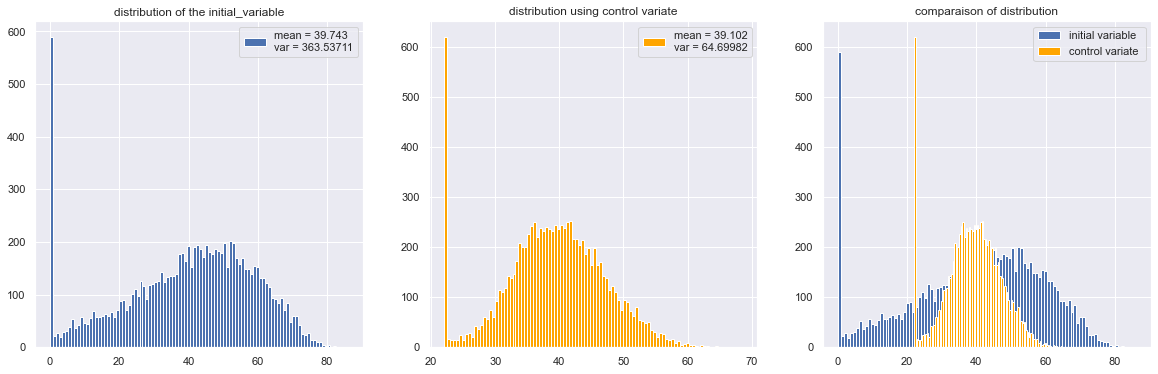

In [ ]:
plot_simulation(y, Y_control)

#### **K = 1.2* S0**

In [ ]:
y, Y_control = simul_put_worst_of(k = 1.2)

Epoch 1/1000
250/250 [==============================] - 1s 2ms/step - loss: 763.2527 - mse: 763.2527 - val_loss: 177.7352 - val_mse: 177.7352
Epoch 2/1000
250/250 [==============================] - 1s 5ms/step - loss: 95.6378 - mse: 95.6378 - val_loss: 64.4103 - val_mse: 64.4103
Epoch 3/1000
250/250 [==============================] - 1s 5ms/step - loss: 53.7671 - mse: 53.7671 - val_loss: 49.1645 - val_mse: 49.1645
Epoch 4/1000
250/250 [==============================] - 1s 2ms/step - loss: 49.0264 - mse: 49.0264 - val_loss: 47.9090 - val_mse: 47.9090
Epoch 5/1000
250/250 [==============================] - 1s 2ms/step - loss: 36.3212 - mse: 36.3212 - val_loss: 30.5721 - val_mse: 30.5721
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 32.8955 - mse: 32.8955 - val_loss: 30.6507 - val_mse: 30.6507
Epoch 7/1000
250/250 [==============================] - 1s 4ms/step - loss: 32.5048 - mse: 32.5048 - val_loss: 29.3588 - val_mse: 29.3588
Epoch 8/1000
250/250 [========

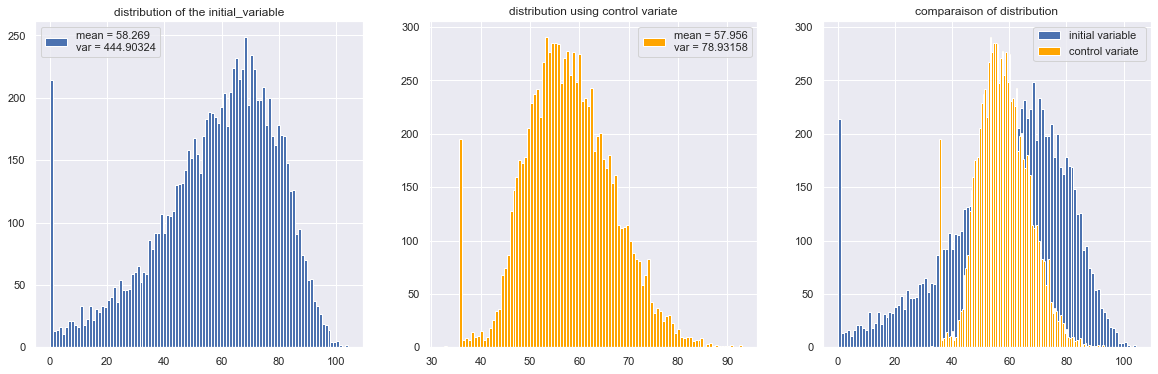

In [ ]:
plot_simulation(y, Y_control)

#### **K = 1.5* S0**

In [ ]:
y, Y_control = simul_put_worst_of(k = 1.5)

Epoch 1/1000
250/250 [==============================] - 1s 2ms/step - loss: 2991.7217 - mse: 2991.7217 - val_loss: 671.4625 - val_mse: 671.4625
Epoch 2/1000
250/250 [==============================] - 0s 2ms/step - loss: 254.0184 - mse: 254.0184 - val_loss: 83.4646 - val_mse: 83.4646
Epoch 3/1000
250/250 [==============================] - 1s 2ms/step - loss: 64.4428 - mse: 64.4428 - val_loss: 58.6624 - val_mse: 58.6624
Epoch 4/1000
250/250 [==============================] - 1s 5ms/step - loss: 57.1776 - mse: 57.1776 - val_loss: 66.3094 - val_mse: 66.3094
Epoch 5/1000
250/250 [==============================] - 1s 5ms/step - loss: 56.3391 - mse: 56.3391 - val_loss: 60.3386 - val_mse: 60.3386
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 56.1934 - mse: 56.1934 - val_loss: 54.2052 - val_mse: 54.2052
Epoch 7/1000
250/250 [==============================] - 1s 5ms/step - loss: 55.9611 - mse: 55.9611 - val_loss: 61.0567 - val_mse: 61.0567
Epoch 8/1000
250/250 [====

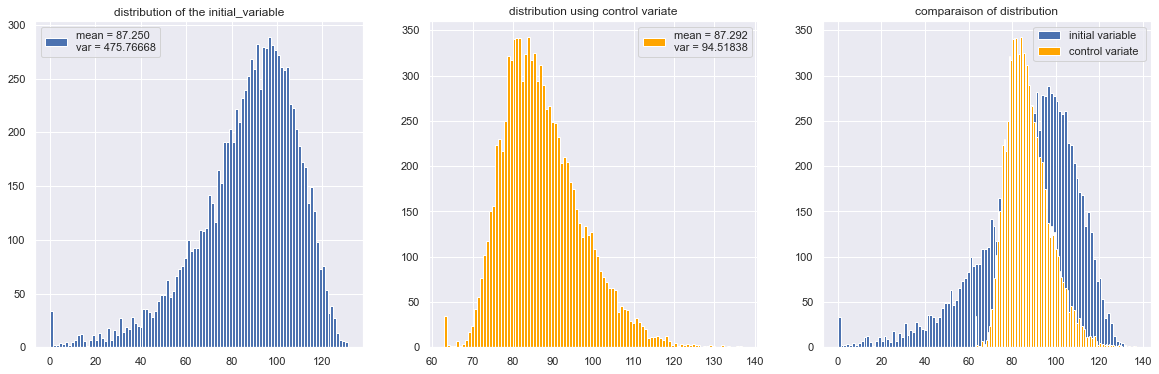

In [ ]:
plot_simulation(y, Y_control)

# Binary option (a digit) on the basket

### 1. Data generation

In [ ]:
Z = multivariate_normal.rvs(cov = np.eye(N), size=M_simulation)
y = f_Digit_Basket(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)
y_train = (y_train == 0).reshape(-1,1)
y_test = (y_test == 0).reshape(-1,1)

In [ ]:
pd.Series(y).value_counts()

0.000000     5447
98.019867    4553
dtype: int64

### 2. Model Creation
for this task we are using a binary classifier

In [ ]:
nnmodel_binary = DNN(N, n = 10, prediction_type="bin_class")

In [ ]:
nnmodel_binary.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True)

Epoch 1/1000
250/250 [==============================] - 2s 3ms/step - loss: 0.2696 - binary_accuracy: 0.8597 - val_loss: 0.1203 - val_binary_accuracy: 0.9510
Epoch 2/1000
250/250 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.9619 - val_loss: 0.1241 - val_binary_accuracy: 0.9485
Epoch 3/1000
250/250 [==============================] - 1s 5ms/step - loss: 0.0755 - binary_accuracy: 0.9671 - val_loss: 0.0902 - val_binary_accuracy: 0.9570
Epoch 4/1000
250/250 [==============================] - 0s 2ms/step - loss: 0.0697 - binary_accuracy: 0.9700 - val_loss: 0.0736 - val_binary_accuracy: 0.9650
Epoch 5/1000
250/250 [==============================] - 0s 2ms/step - loss: 0.0612 - binary_accuracy: 0.9746 - val_loss: 0.0696 - val_binary_accuracy: 0.9710
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 0.0578 - binary_accuracy: 0.9768 - val_loss: 0.0721 - val_binary_accuracy: 0.9650
Epoch 7/1000
250/250 [==============================

### 3. Test  and evaluation of the model

In [ ]:
Z = multivariate_normal.rvs(cov = np.eye(N), size=M_simulation)
y = f_Digit_Basket(Z)
y = y == 0
y_pred = nnmodel_binary.model.predict(Z)
y_pred = y_pred > 0.5

313/313 [==============================] - 1s 2ms/step


In [ ]:
accuracy_score(y, y_pred)

0.969

### 4. Simulation

In [ ]:
U = nnmodel_binary.model.get_weights()[0].T

In [ ]:
matrix_rank(U) # we check that our matrix have maximal rank

10

In [ ]:
f = lambda x : f_Digit_Basket(x)
y, Y_control = simulation(U, f)

U.shape (10, 100)
[1.         1.0000001  0.99999994 1.0000001  1.0000001  1.
 1.0000002  0.9999999  0.99999994 1.0000001 ]
V.shape (90, 100)
M.shape (100, 100)
Z_simul.shape (10000, 100)


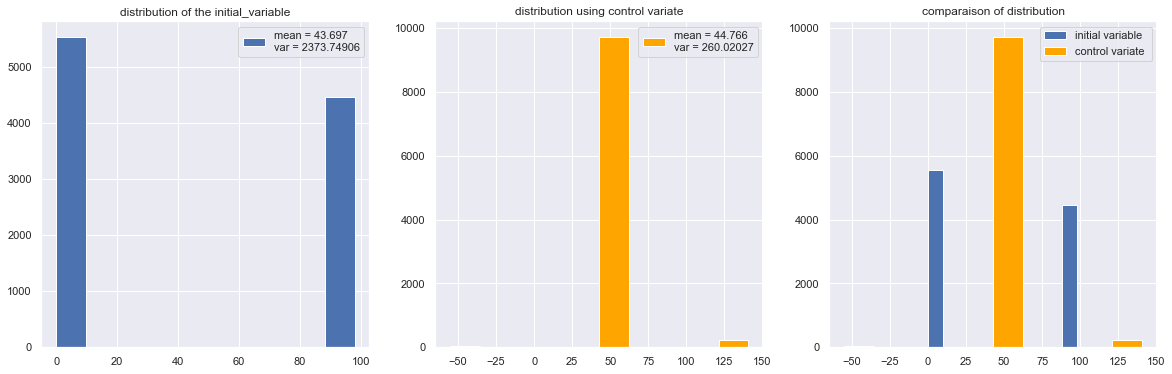

In [ ]:
plot_simulation(y, Y_control, bins = [10,10, 10, 10])

In [ ]:
y.var()/Y_control.var()

9.129092320602266

The variance of this method is very high because G = 100 and var(GZ) = G^2 * var(Z)

# Arithmetic asian option

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, N * Neuler)
y = f_Asian_Arithmetic(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_asian = DNN(N * Neuler, n = 10)

In [ ]:
nnmodel_asian.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 10)

Epoch 1/1000
2500/2500 [==============================] - 7s 2ms/step - loss: 20.5598 - mse: 20.5598 - val_loss: 4.0938 - val_mse: 4.0938
Epoch 2/1000
2500/2500 [==============================] - 9s 4ms/step - loss: 5.5531 - mse: 5.5531 - val_loss: 4.9950 - val_mse: 4.9950
Epoch 3/1000
2500/2500 [==============================] - 7s 3ms/step - loss: 4.1798 - mse: 4.1798 - val_loss: 3.5835 - val_mse: 3.5835
Epoch 4/1000
2500/2500 [==============================] - 7s 3ms/step - loss: 3.4265 - mse: 3.4265 - val_loss: 2.7620 - val_mse: 2.7620
Epoch 5/1000
2500/2500 [==============================] - 6s 2ms/step - loss: 3.2990 - mse: 3.2990 - val_loss: 3.4691 - val_mse: 3.4691
Epoch 6/1000
2500/2500 [==============================] - 5s 2ms/step - loss: 2.4140 - mse: 2.4140 - val_loss: 2.0439 - val_mse: 2.0439
Epoch 7/1000
2500/2500 [==============================] - 6s 2ms/step - loss: 2.4535 - mse: 2.4535 - val_loss: 3.3865 - val_mse: 3.3865
Epoch 8/1000
2500/2500 [======================

In [ ]:
# Save or load the model
filename = 'Asian_BS.sav'
pickle.dump(nnmodel_asian, open(filename, 'wb'))
#nnmodel_asian = pickle.load(open(filename, 'rb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2022-12-08 12:56:13         2626
metadata.json                                  2022-12-08 12:56:13           64
variables.h5                                   2022-12-08 12:56:13       148520


### 3. Test  and evaluation of the model

In [ ]:
Z = np.random.randn(M_simulation, N * Neuler)
y = f_Asian_Arithmetic(Z)
y_pred = nnmodel_asian.model.predict(Z)
print('Monte Carlo price = {:.4}. Control variate price = {:.4}'.format(np.mean(y), np.mean(y_pred)))
mean_squared_error(y, y_pred)

313/313 [==============================] - 1s 2ms/step
Monte Carlo price = 9.149. Control variate price = 8.997


0.6315936625369213

### 4. Simulation

In [ ]:
W = nnmodel_asian.model.get_weights()[0].T

In [ ]:
print(matrix_rank(W)==len(W))
matrix_rank(W) # we check that our matrix have maximal rank

True


10

In [ ]:
k = 1
f = lambda x : f_Asian_Arithmetic(x, K = k*K)
y, Y_control = simulation(W, f, N * Neuler)

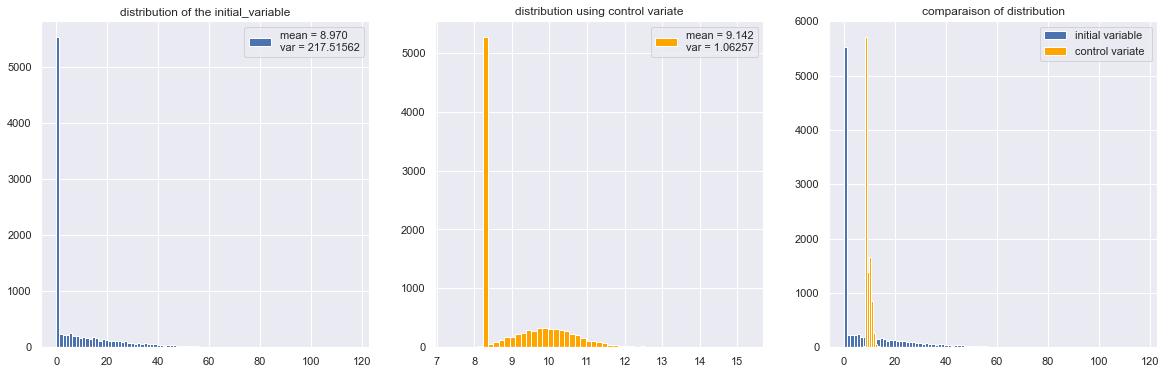

In [ ]:
plot_simulation(y, Y_control, ['auto', 'auto', 'auto', 10])

In [ ]:
MC, CV = simulation(W, f_Asian_Arithmetic, N * Neuler)
print(np.mean(MC), np.mean(CV))

8.798757261687493 9.110291350065394


### 5. Robustness

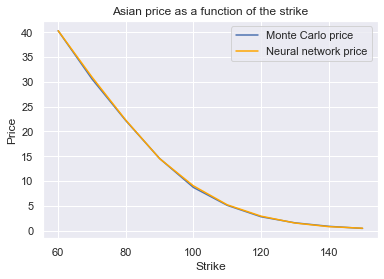

In [ ]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, K = k*K)
    MC, CV = simulation(W, f, N * Neuler)
    y_MC[i], y_CV[i] = np.mean(MC), np.mean(CV)
plt.title('Asian price as a function of the strike')
plt.plot(k_list * K, y_MC, label = "Monte Carlo price")
plt.plot(k_list * K, y_CV, color='orange', label = "Neural network price")
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend()
plt.show()

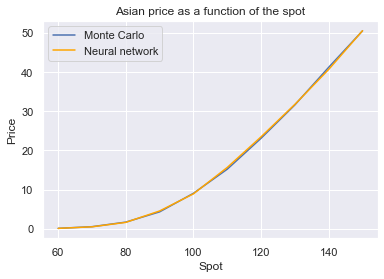

In [ ]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, S0 = k*S0)
    MC, CV = simulation(W, f, N * Neuler)
    y_MC[i], y_CV[i] = np.mean(MC), np.mean(CV)
plt.title('Asian price as a function of the spot')
plt.plot(k_list * S0, y_MC, label = "Monte Carlo")
plt.plot(k_list * S0, y_CV, color='orange', label = "Neural network")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend()
plt.show()

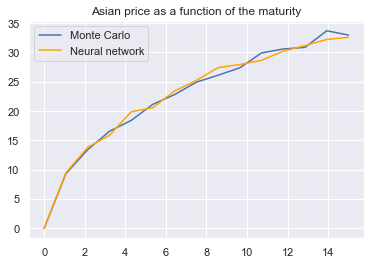

In [ ]:
k_list = np.linspace(0, 15, 15)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_Asian_Arithmetic(x, T = k * T)
    MC, CV = simulation(W, f, N * Neuler)
    y_MC[i], y_CV[i] = np.mean(MC), np.mean(CV)
plt.title('Asian price as a function of the maturity')
plt.plot(k_list * T, y_MC, label = "Monte Carlo")
plt.plot(k_list * T, y_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

# AutoCall

In [ ]:
Z = np.random.randn(nb_samples, N * Neuler)
y = f_AutoCall(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_autocall = DNN(N * Neuler, n = 10)

In [ ]:
nnmodel_autocall.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 5)

Epoch 1/1000
5000/5000 [==============================] - 9s 1ms/step - loss: 133.0958 - mse: 133.0958 - val_loss: 106.8953 - val_mse: 106.8953
Epoch 2/1000
5000/5000 [==============================] - 7s 1ms/step - loss: 86.8402 - mse: 86.8402 - val_loss: 78.2189 - val_mse: 78.2189
Epoch 3/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 73.1314 - mse: 73.1314 - val_loss: 73.2102 - val_mse: 73.2102
Epoch 4/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 65.6637 - mse: 65.6637 - val_loss: 62.6973 - val_mse: 62.6973
Epoch 5/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 59.3008 - mse: 59.3008 - val_loss: 53.5723 - val_mse: 53.5723
Epoch 6/1000
5000/5000 [==============================] - 6s 1ms/step - loss: 54.0619 - mse: 54.0619 - val_loss: 54.0969 - val_mse: 54.0969
Epoch 7/1000
5000/5000 [==============================] - 7s 1ms/step - loss: 51.8168 - mse: 51.8168 - val_loss: 47.6441 - val_mse: 47.6441
Epoch 8/1000
500

### 3. Test  and evaluation of the model

In [ ]:
Z = np.random.randn(M_simulation, N * Neuler)
y = f_AutoCall(Z)
y_pred = nnmodel_autocall.model.predict(Z)
mean_squared_error(y, y_pred)

313/313 [==============================] - 2s 3ms/step


44.006831856790825

### 4. Simulation

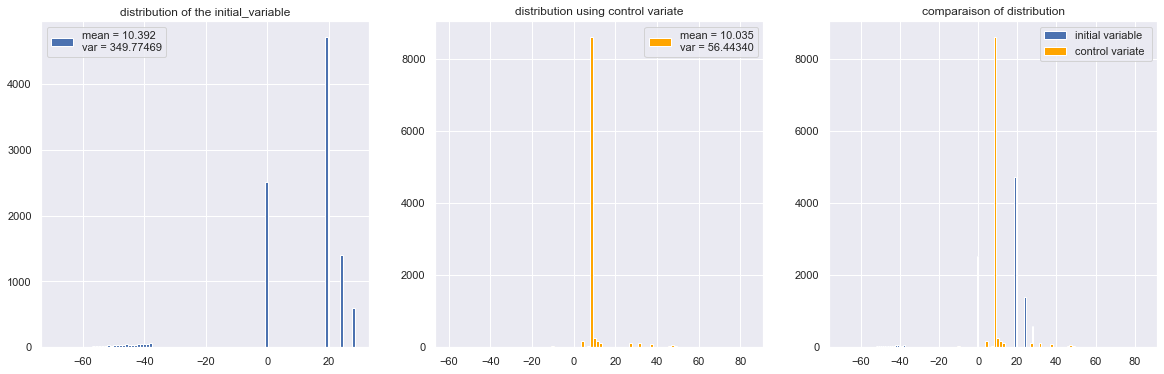

In [ ]:
U = nnmodel_autocall.model.get_weights()[0].T
matrix_rank(U) # we check that our matrix has maximal rank
y, Y_control = simulation(U, f_AutoCall, N * Neuler)
plot_simulation(y, Y_control)

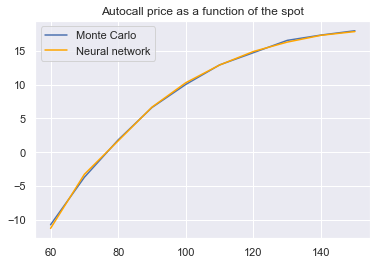

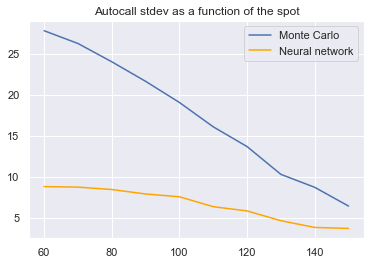

In [ ]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
y_std_MC = np.zeros(len(k_list))
y_std_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_AutoCall(x, S0 = k * S0)
    a, b = simulation(U, f, N * Neuler)
    y_MC[i], y_std_MC[i] = np.mean(a), np.std(a)
    y_CV[i], y_std_CV[i] = np.mean(b), np.std(b)
plt.figure()
plt.title('Autocall price as a function of the spot')
plt.plot(k_list * S0, y_MC, label = "Monte Carlo")
plt.plot(k_list * S0, y_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

plt.figure()
plt.title('Autocall stdev as a function of the spot')
plt.plot(k_list * S0, y_std_MC, label = "Monte Carlo")
plt.plot(k_list * S0, y_std_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

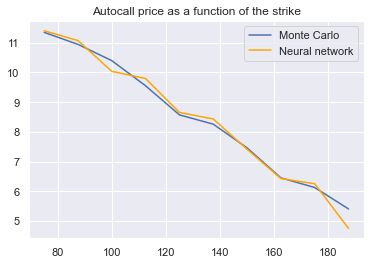

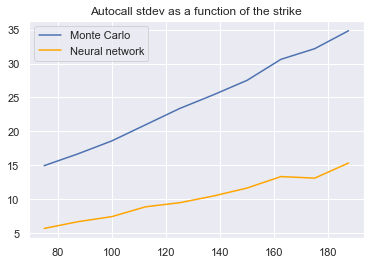

In [ ]:
k_list = np.linspace(0.75, 1.875, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
y_std_MC = np.zeros(len(k_list))
y_std_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_AutoCall(x, K = k * K_AC)
    a, b = simulation(U, f, N * Neuler)
    y_MC[i], y_std_MC[i] = np.mean(a), np.std(a)
    y_CV[i], y_std_CV[i] = np.mean(b), np.std(b)
plt.figure()
plt.title('Autocall price as a function of the strike')
plt.plot(k_list * K, y_MC, label = "Monte Carlo")
plt.plot(k_list * K, y_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

plt.figure()
plt.title('Autocall stdev as a function of the strike')
plt.plot(k_list * K, y_std_MC, label = "Monte Carlo")
plt.plot(k_list * K, y_std_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

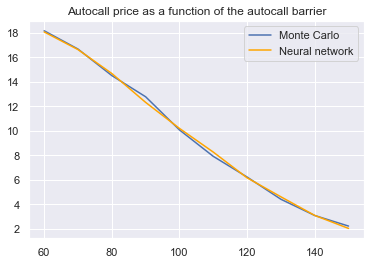

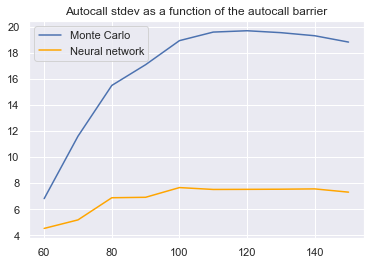

In [ ]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
y_std_MC = np.zeros(len(k_list))
y_std_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_AutoCall(x, AB = k * AB)
    a, b = simulation(U, f, N * Neuler)
    y_MC[i], y_std_MC[i] = np.mean(a), np.std(a)
    y_CV[i], y_std_CV[i] = np.mean(b), np.std(b)
plt.figure()
plt.title('Autocall price as a function of the autocall barrier')
plt.plot(k_list * AB, y_MC, label = "Monte Carlo")
plt.plot(k_list * AB, y_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

plt.figure()
plt.title('Autocall stdev as a function of the autocall barrier')
plt.plot(k_list * AB, y_std_MC, label = "Monte Carlo")
plt.plot(k_list * AB, y_std_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

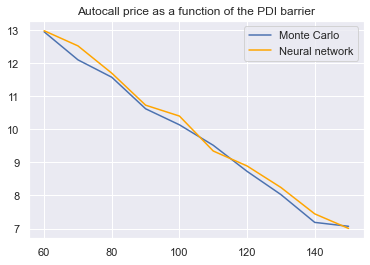

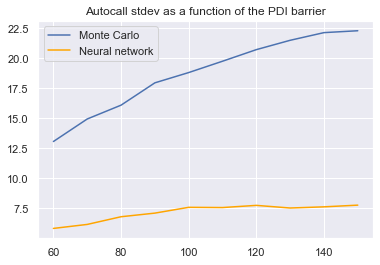

In [ ]:
k_list = np.linspace(0.6, 1.5, 10)
y_MC = np.zeros(len(k_list))
y_CV = np.zeros(len(k_list))
y_std_MC = np.zeros(len(k_list))
y_std_CV = np.zeros(len(k_list))
for i, k in enumerate(k_list):
    f = lambda x : f_AutoCall(x, DB= k * DB)
    a, b = simulation(U, f, N * Neuler)
    y_MC[i], y_std_MC[i] = np.mean(a), np.std(a)
    y_CV[i], y_std_CV[i] = np.mean(b), np.std(b)
plt.figure()
plt.title('Autocall price as a function of the PDI barrier')
plt.plot(k_list * AB, y_MC, label = "Monte Carlo")
plt.plot(k_list * AB, y_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()

plt.figure()
plt.title('Autocall stdev as a function of the PDI barrier')
plt.plot(k_list * AB, y_std_MC, label = "Monte Carlo")
plt.plot(k_list * AB, y_std_CV, color='orange', label = "Neural network")
plt.legend()
plt.show()